In [1]:
import numpy as np
import pandas as pd
import torch
import random
import copy
import sys
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib

from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)

import  matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class CFJointLoss(nn.Module):

    def __init__(self, lambda_ = 0.5):
        super().__init__()
        self.lambda_ = lambda_
        self.loss = nn.BCELoss()

    def euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def cls_loss(self, pred1, pred2, target1, target2):
        return self.loss(pred1, target1) + self.loss(pred2, target2) + 1e-8

    def forward(self, query_x, cf_x, base_x, pred_x, pred_cf, pred_base, target_x, target_cf):

        distance1 = (pred_cf - pred_x).squeeze().abs() / self.euclidean(query_x, cf_x)
        distance2 = (pred_base - pred_x).squeeze().abs() / self.euclidean(query_x, base_x)
        triplet_loss = F.relu(distance2 - distance1).mean()
        classification_loss = self.cls_loss(pred_x, pred_cf, target_x, target_cf)
        total_loss = classification_loss + self.lambda_ * triplet_loss
        return total_loss, classification_loss, triplet_loss


In [3]:
dquery = np.load("../../data/synthetic_v1/synthetic_query_v1.npy").astype(np.float32)
dval = np.load("../../data/synthetic_v1/synthetic_val_v1.npy").astype(np.float32)
dtest = np.load("../../data/synthetic_v1/synthetic_test_v1.npy").astype(np.float32)
dcf = np.load("../../data/synthetic_v1/synthetic-plaincf.npy").astype(np.float32)

query_x, query_y = dquery[:, 0:2], dquery[:, 2:3]
cf_x, cf_y = dcf[:, 0:2], np.round(1 - query_y).astype(np.float32)
val_x, val_y = dval[:, 0:2], dval[:, 2:3]
test_x, test_y = dtest[:, 0:2], dtest[:, 2:3]

scaler = MinMaxScaler()
query_x = scaler.fit_transform(query_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)
cf_x = scaler.transform(cf_x)

query_x, val_x, test_x, cf_x = torch.from_numpy(query_x), torch.from_numpy(val_x), torch.from_numpy(test_x), torch.from_numpy(cf_x)
query_y, val_y, test_y, cf_y = torch.from_numpy(query_y), torch.from_numpy(val_y), torch.from_numpy(test_y), torch.from_numpy(cf_y)

a = list(range(len(query_x)))
length = 2
sample_len = 200
#seed = 0
#random.seed(seed)
#torch.manual_seed(seed)
random.shuffle(a)
idx = a[0:length]
query_sx, query_sy = query_x[idx], query_y[idx]
cf_sx, cf_sy = cf_x[idx], cf_y[idx]

In [4]:
scaler.inverse_transform(query_sx.numpy())

array([[1.4413875, 1.5695614],
       [3.835452 , 3.0669248]], dtype=float32)

In [5]:
query_rsx = query_sx.repeat(sample_len, 1)
query_rsy = query_sy.repeat(sample_len, 1)
cf_rsx = cf_sx.repeat(sample_len, 1)
cf_rsy = cf_sy.repeat(sample_len, 1)
noise = torch.rand(sample_len * length, 2)

In [6]:
query_rsx.shape

torch.Size([400, 2])

In [7]:
Train = TensorDataset(query_rsx, cf_rsx, noise, query_rsy, cf_rsy)
Test = TensorDataset(test_x, test_y)

train_loader = DataLoader(Train, batch_size  = sample_len * length)
test_loader = DataLoader(Test, batch_size = sample_len * length)



In [8]:
h = 0.02
x_min, x_max = 0, 6
y_min, y_max = 0, 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

In [9]:
dplot = np.c_[xx.ravel(), yy.ravel()]
_dplot = scaler.transform(dplot).astype(np.float32)
_dplot = torch.from_numpy(_dplot)

<Figure size 360x360 with 0 Axes>

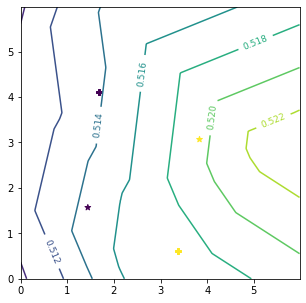

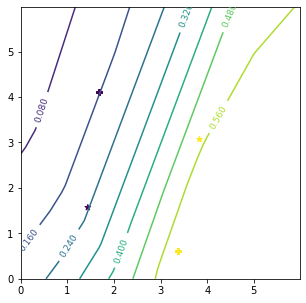

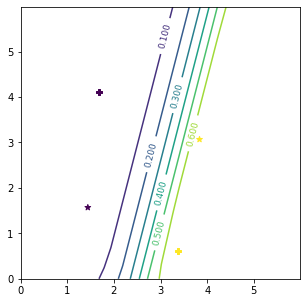

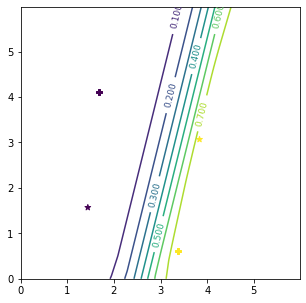

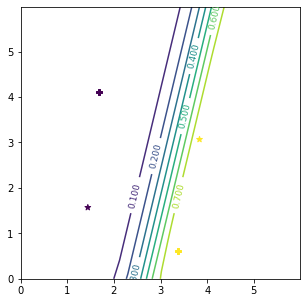

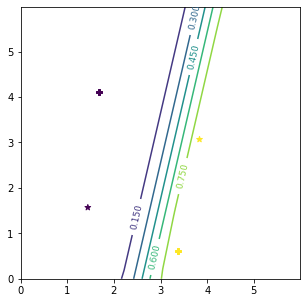

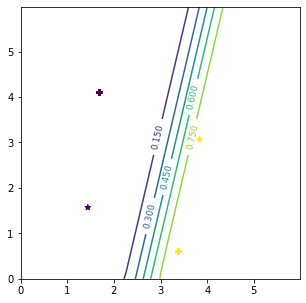

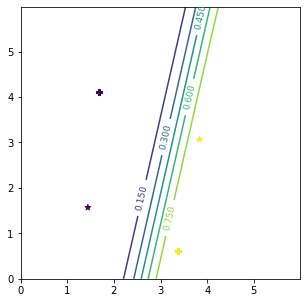

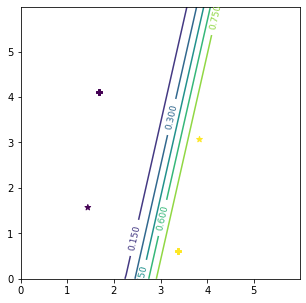

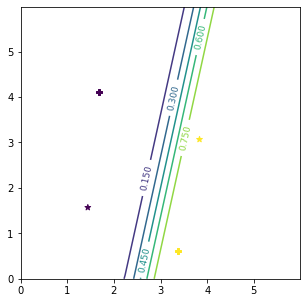

In [10]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)

optimizer = optim.Adam(model.parameters(), lr = 0.005)
criterion1 = nn.BCELoss()
criterion2 = CFJointLoss(lambda_ = 0)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = model.to(device)
criterion1 = criterion1.to(device)
criterion2 = criterion2.to(device)

best_model = None
best_acc = -float('inf')

plt.ion() # something about plotting

fig = plt.figure(figsize=(5,5))
fig.clf()

for t in range(500):
    
    epoch_loss, cls_loss, t_loss = 0, 0, 0
    model.train()
    prediction = []
    label = []
    
    for _, (query_x, cf_x, base_x, query_y, cf_y) in enumerate(train_loader):
        
        query_x, cf_x, base_x, query_y, cf_y = query_x.to(device), cf_x.to(device), base_x.to(device), query_y.to(device), cf_y.to(device)
        optimizer.zero_grad()
        output1 = model(query_x)
        output2 = model(cf_x)
        output3 = model(base_x)
        loss, classification_loss, triplet_loss = criterion2(query_x, cf_x, base_x, output1, output2, output3, query_y, cf_y)
        loss.backward()
        optimizer.step()
        preds = torch.round(output1)
        epoch_loss += loss.item() * len(query_x)
        cls_loss += classification_loss.item() * len(query_x)
        t_loss += triplet_loss.item() * len(query_x)
        label.extend(query_y.reshape(-1).tolist())
        prediction.extend(preds.reshape(-1).tolist())

#     acc = accuracy_score(label, prediction)
#     print(acc, epoch_loss / len(train_loader.dataset))

    if t % 50 == 0:
        # plot and show learning process
        #plt.cla()
        fig = plt.figure(figsize=(5,5))
        fig.clf()
        xx_ = scaler.inverse_transform(query_sx.numpy())
        y = query_sy.numpy().squeeze()
        plt.scatter(xx_[:, 0], xx_[:, 1], c = y, marker = "*")
        cf = scaler.inverse_transform(cf_sx.numpy())
        y_ = cf_sy.numpy().squeeze()
        #print(cf, y_)
        plt.scatter(cf[:, 0], cf[:, 1], c = y_, marker = "P")
        
#         base_xx = scaler.inverse_transform(base_x.numpy())
#         plt.scatter(base_xx[:, 0], base_xx[:, 1], marker = "o")
#         for i in range(length):
#             plt.annotate(i, (xx_[i, 0], xx_[i, 1]))
#             plt.annotate(i, (cf[i, 0], cf[i, 1]))
# #             for j in range(sample_len):
#                 plt.annotate(i, (base_xx[i*sample_len+j, 0], base_xx[i*sample_len+j, 1]))
        
                
        S = model(_dplot).detach().numpy()
        S = S.reshape(xx.shape)
        CS = plt.contour(xx, yy, S)
        plt.clabel(CS, fontsize=9, inline=1)
        plt.pause(0.1)

plt.ioff()
plt.show()